# 用卷积神经网络处理序列

In [1]:
from function import *

## 实现一维卷积神经网络

In [2]:
# 准备IMDB数据
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
print("Loading data...")
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words = max_features)
print(len(x_train),'train sequences')
print(len(x_test),'test sequences')

print('Pad sequences (sample x time)')
x_train = sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = sequence.pad_sequences(x_test,maxlen=maxlen)
print('x_train shape:',x_train.shape)
print('x_test shape:',x_test.shape)

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (sample x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [3]:
# 在IMDB数据上训练并评估一个简单的一维卷积神经网络
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable para

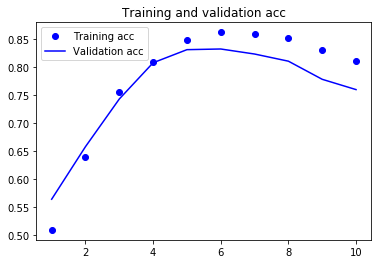

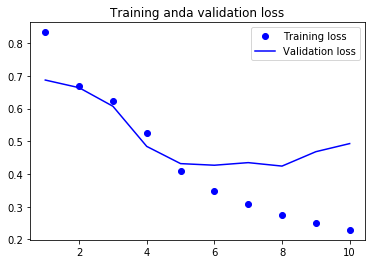

In [4]:
draw_curve(history)

## 结合CNN和RNN来处理长序列

In [5]:
jena_data = './data/jena_climate_2009_2016.csv'
import os 

f =open(jena_data)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
# 解析数据
import numpy as np

float_data = np.zeros((len(lines),len(header)-1))

for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

In [7]:
# 数据标准化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
# 生成时间序列样本及其目标的生成器
def generator(data,lookback,delay,min_index,max_index,shuffle = False,batch_size=128,step=6):
    if max_index is None:
        max_index = len(data)-delay-1
    i = min_index+lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i = min_index+lookback
            rows = np.arrange(i,min(i+batch_size,max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback//step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],step)
            samples[j] =data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples,targets

In [9]:
# 准备训练生成器，验证生成器和测试生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback = lookback,
                     delay =delay,
                     min_index = 0,
                     max_index = 200000,
                     shuffle = True,
                     step=step,
                     batch_size = batch_size)

val_gen = generator(float_data,
                     lookback = lookback,
                     delay =delay,
                     min_index = 200001,
                     max_index = 300000,
                     shuffle = True,
                     step=step,
                     batch_size = batch_size)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay =delay,
                     min_index = 200001,
                     max_index = 300000,
                     shuffle = True,
                     step=step,
                     batch_size = batch_size)

val_steps = (300000-200001-lookback)//batch_size

test_steps = (len(float_data)-300001-lookback)//batch_size


In [11]:
# 在耶拿数据上训练并评估一个简单的一维卷积神经网络
model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

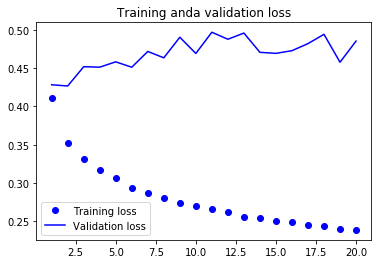

In [12]:
draw_loss(history)

In [13]:
# 为耶拿数据集准备更高分辨率的数据生成器
step=3
lookback=720
delay=144

train_gen = generator(float_data,
                     lookback = lookback,
                     delay =delay,
                     min_index = 0,
                     max_index = 200000,
                     shuffle = True,
                     step=step)

val_gen = generator(float_data,
                     lookback = lookback,
                     delay =delay,
                     min_index = 200001,
                     max_index = 300000,
                     shuffle = True,
                     step=step)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay =delay,
                     min_index = 200001,
                     max_index = 300000,
                     shuffle = True,
                     step=step)

val_steps = (300000-200001-lookback)//128

test_steps = (len(float_data)-300001-lookback)//128

In [14]:
# 结合一维卷积基和GRU层的模型
model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [===

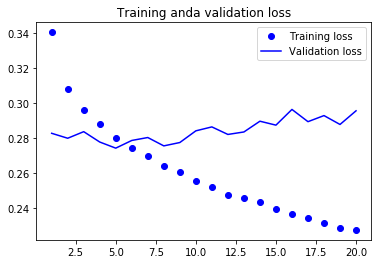

In [15]:
draw_loss(history)